In [60]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import scipy as sp
import time

# **Problem 1: Euler's Method**


In [61]:
"""
The derivative function
"""
def derivative(t):
  return -2 * math.exp(-4 * t) + math.exp(-2 * t)

"""
The actual function
"""
def function(t):
  return 1 + (1/2) * math.exp(-4 * t) - (1/2) * math.exp(-2 * t)

### **b)**

In [62]:
"""
This function calculates Euler's method integration.
"""
def euler_method(derivative, target_value, initial_condition_value, h = .001):
  output = []
  x_values = [0]
  output.append(initial_condition_value)

  idx = 1
  t = 0

  while t <= target_value: # loop until we reach the highest value
    t += h

    x_values.append(t)
    output.append(output[idx - 1] + h * derivative(t))
    idx += 1


  return output, x_values

"""
This function is for calculating the actual values of y
"""
def actual_values(function, target_value, initial_condition_value, h = .001):
  output = []
  output.append(initial_condition_value)
  x_values = [0]

  # increment and loop over t
  t = 0

  while t <= target_value: # loop through until values are reached
    t += h
    x_values.append(t)
    output.append(function(t))

  return output, x_values

In [63]:
"""
This function automatically graphs euler's method with respect to the actual value
"""
def plot_euler_v_actual(euler_x, euler_y, actual_x, actual_y, title = "Method Comparisons"):
  plt.plot(euler_x, euler_y, color = 'blue', label = "Euler's Method", linestyle = "--")
  plt.plot(actual_x, actual_y, color = 'red', label = "Actual Value")
  plt.title(title)
  plt.xlabel("t")
  plt.ylabel("Value")
  plt.legend(loc = "upper left")
  plt.show()

In [64]:
euler_method_output, x_values = euler_method(derivative = derivative, target_value = 1, initial_condition_value= 1)
actual_method_output, actual_x_values = actual_values(function = function, target_value = 1, initial_condition_value= 1)

# testing
# plot_euler_v_actual(x_values, euler_method_output, actual_x_values, actual_method_output)

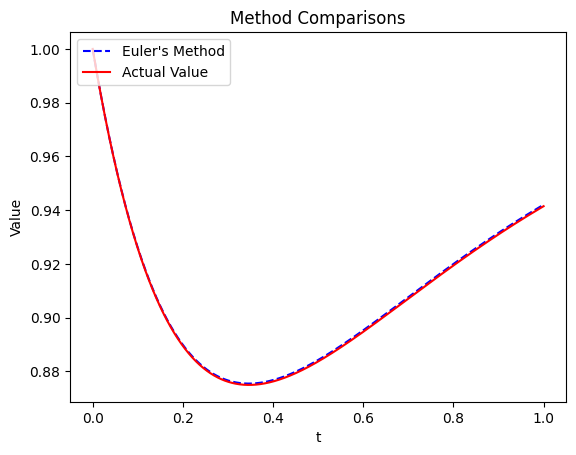

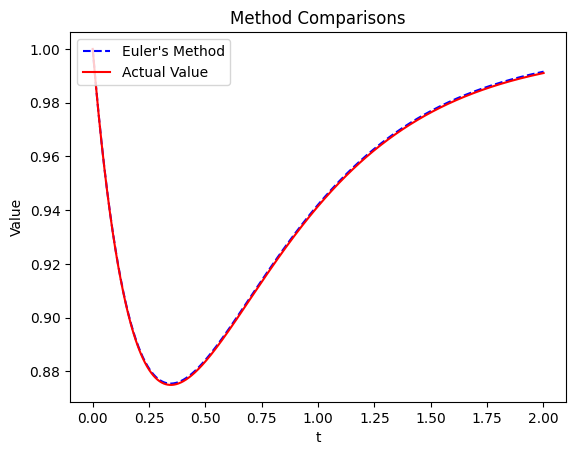

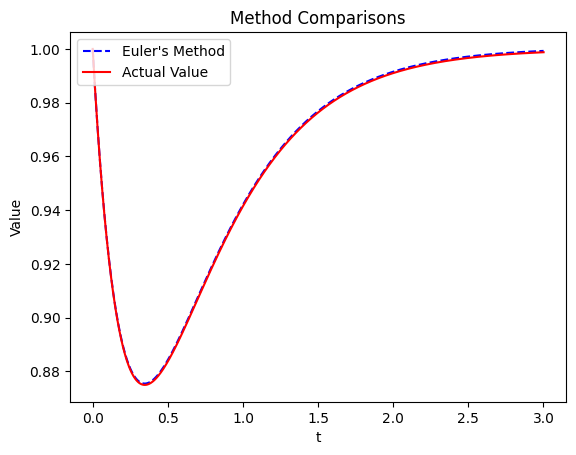

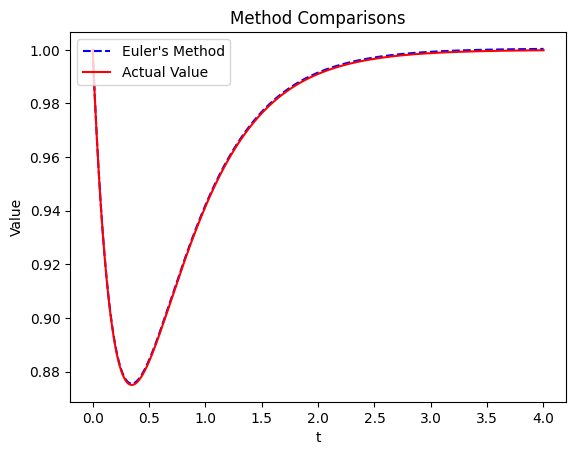

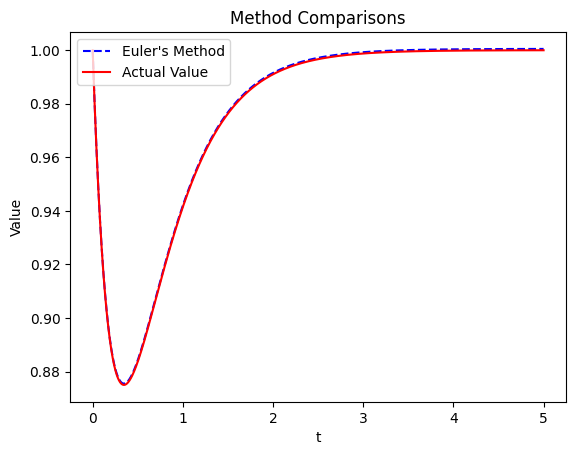

y(1) - Euler's Method: 0.9420390194835017, Actual Value: 0.9414901778260608
y(2) - Euler's Method: 0.9915358421949086, Actual Value: 0.9910275396198439
y(3) - Euler's Method: 0.9992668904011189, Actual Value: 0.9987661600290384
y(4) - Euler's Method: 1.0003323270849547, Actual Value: 0.9998326598564039
y(5) - Euler's Method: 1.00047682375621, Actual Value: 0.9999773010656955



In [65]:
t_list = {1, 2, 3, 4, 5} # list of solutions targets

euler_v_actual_string = "" # string for printing the table

for target_value in t_list: # loop through all target values
  # calculate the outputs
  euler_method_output, euler_x_values = euler_method(derivative = derivative, target_value = target_value, initial_condition_value = 1)
  actual_method_output, actual_x_values = actual_values(function = function, target_value = target_value, initial_condition_value = 1)

  euler_v_actual_string += f"y({target_value}) - Euler's Method: {euler_method_output[-1]}, Actual Value: {actual_method_output[-1]}\n"

  # plot the values
  plot_euler_v_actual(euler_x = euler_x_values, euler_y = euler_method_output,
                      actual_x = actual_x_values, actual_y = actual_method_output)

# print a table
print(euler_v_actual_string)

## **c)**

In [66]:
h_values = [.1, .05, .01, .005, .001] # try different h values

# plot the h_values with their respective t_values
def plot_t(h_values = [1], t = 1):

  fig = plt.figure(figsize = (50, 10))
  fig.suptitle(f"Euler's Method for t = {t}", fontsize = 16)

  # set the graph index
  idx = 1

  for h_value in h_values: # loop h-values
    fig.add_subplot(1, 5, idx)
    euler_method_output, euler_x_values = euler_method(derivative = derivative, target_value = t, initial_condition_value = 1, h = h_value)

    plt.plot(euler_x_values, euler_method_output, color = 'blue', label = "Euler's Method", linestyle = "--")
    plt.xlabel("t")
    plt.ylabel("Value")
    plt.title(f"h = {h_value}")


    # update the index
    idx += 1

# testing purposes
# plot_t(h_values = h_values)

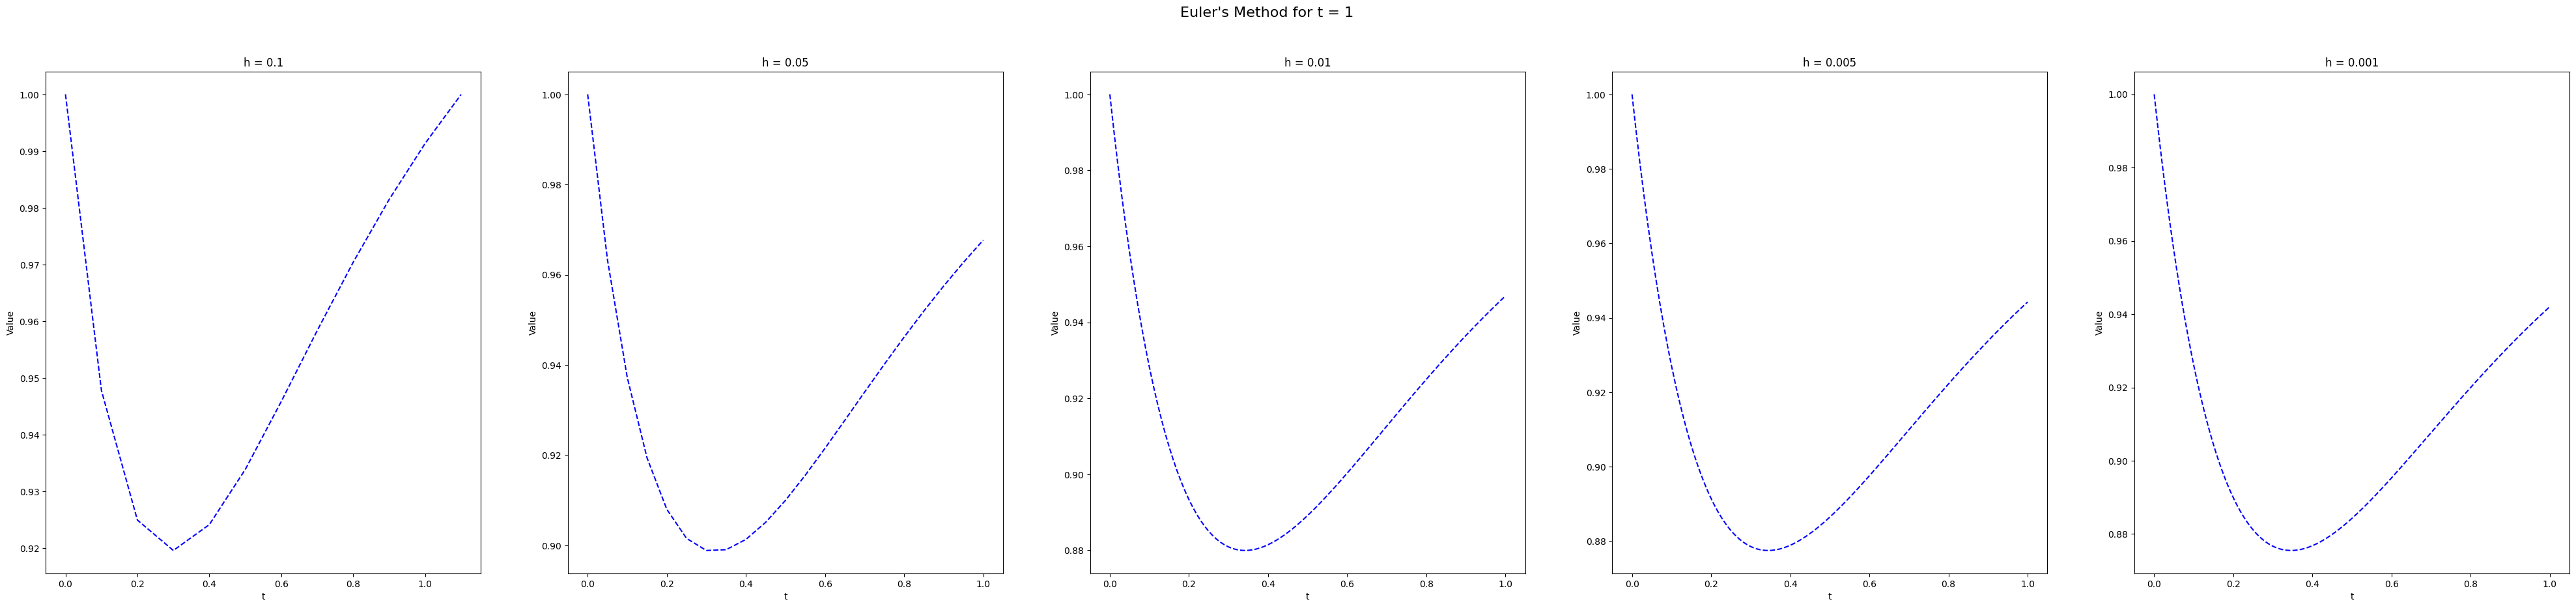

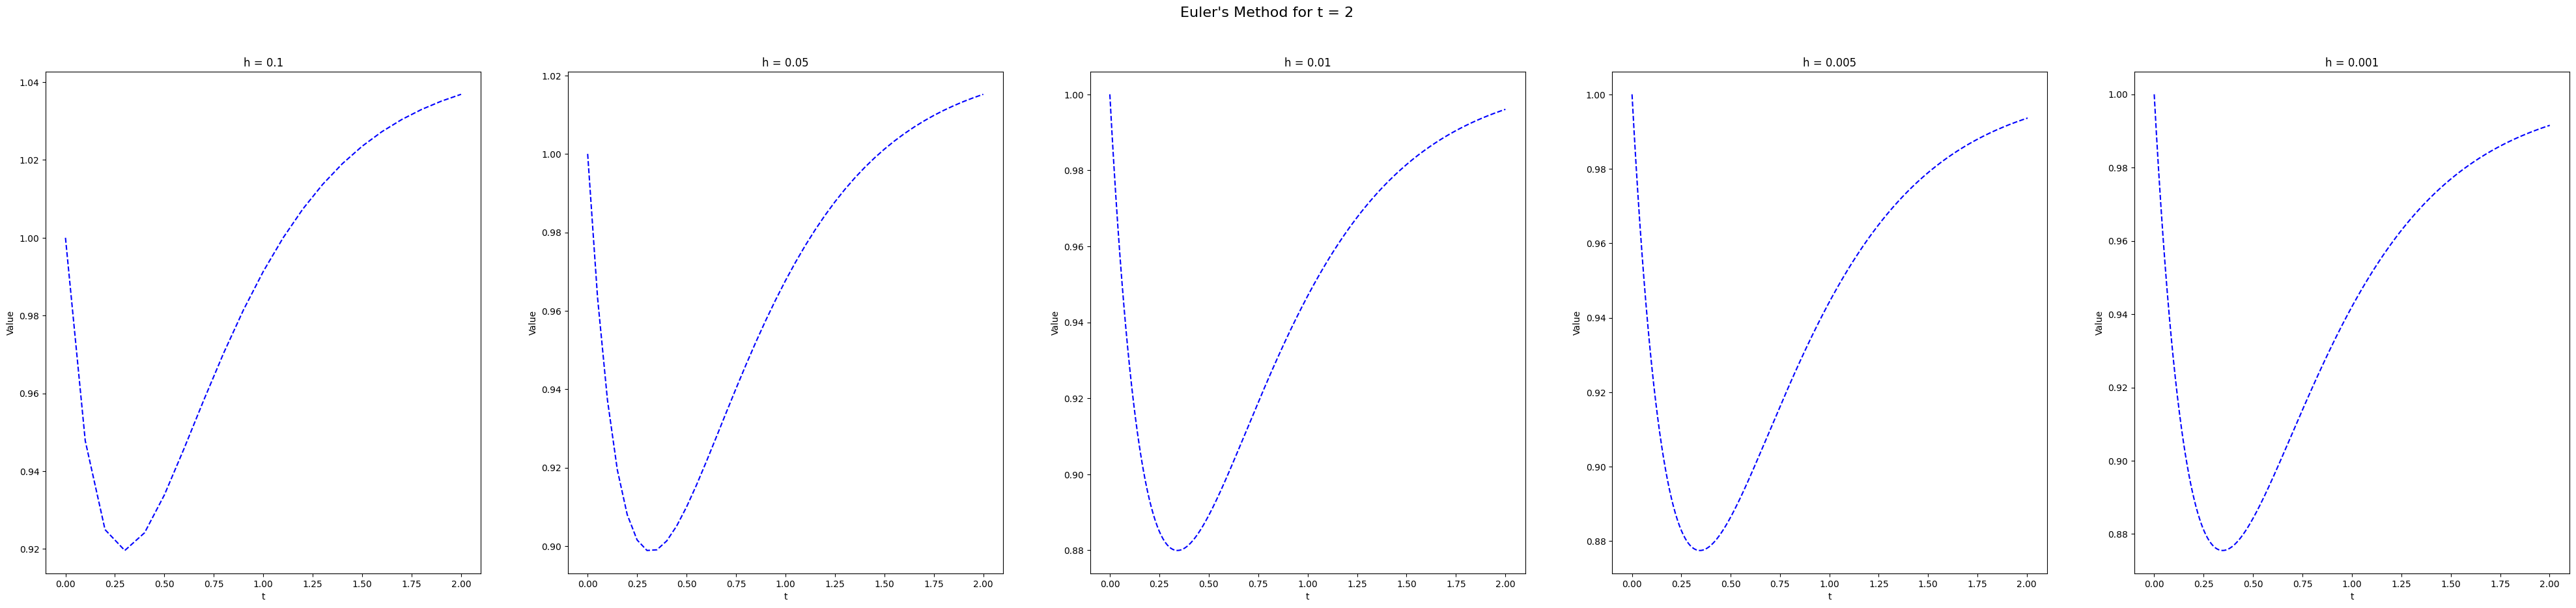

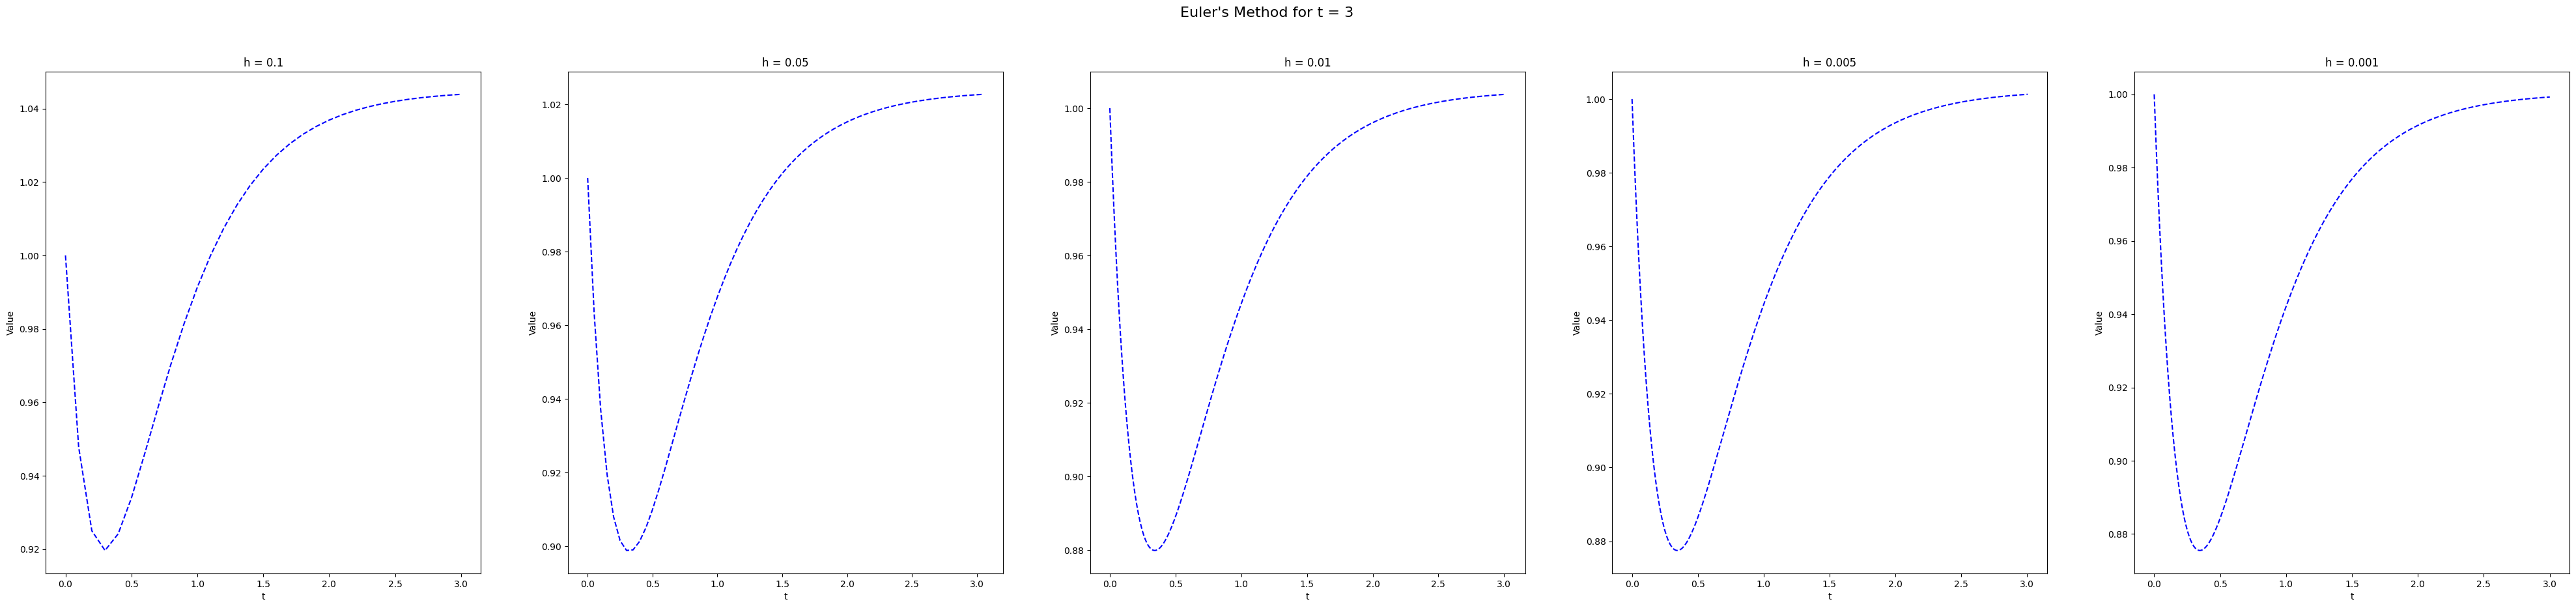

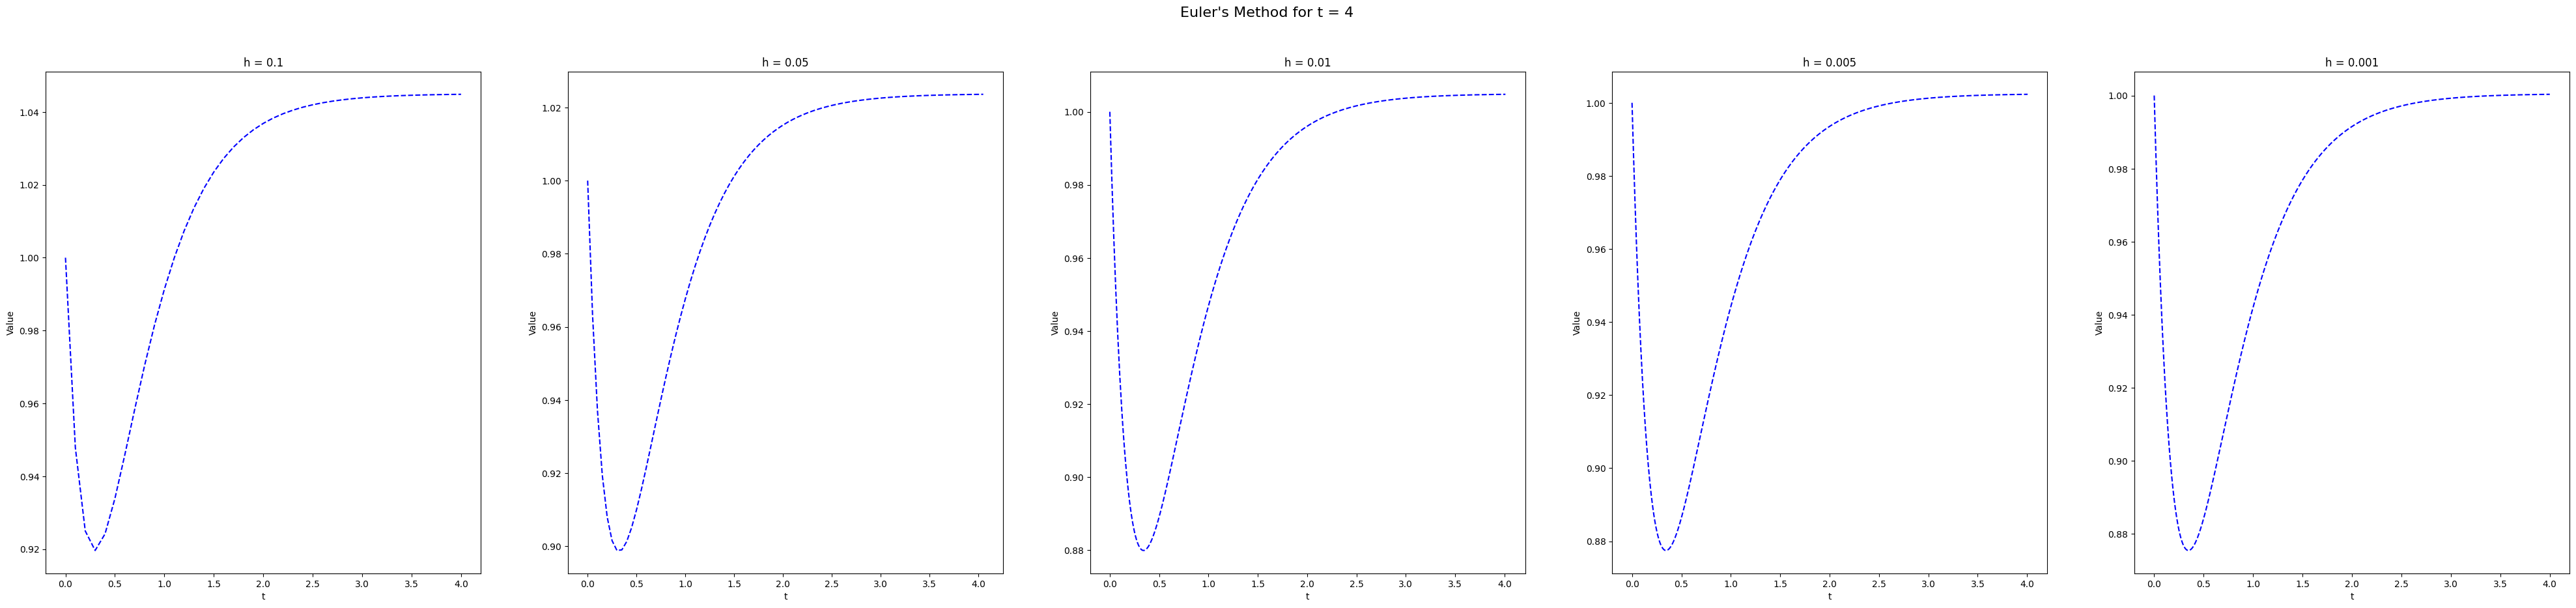

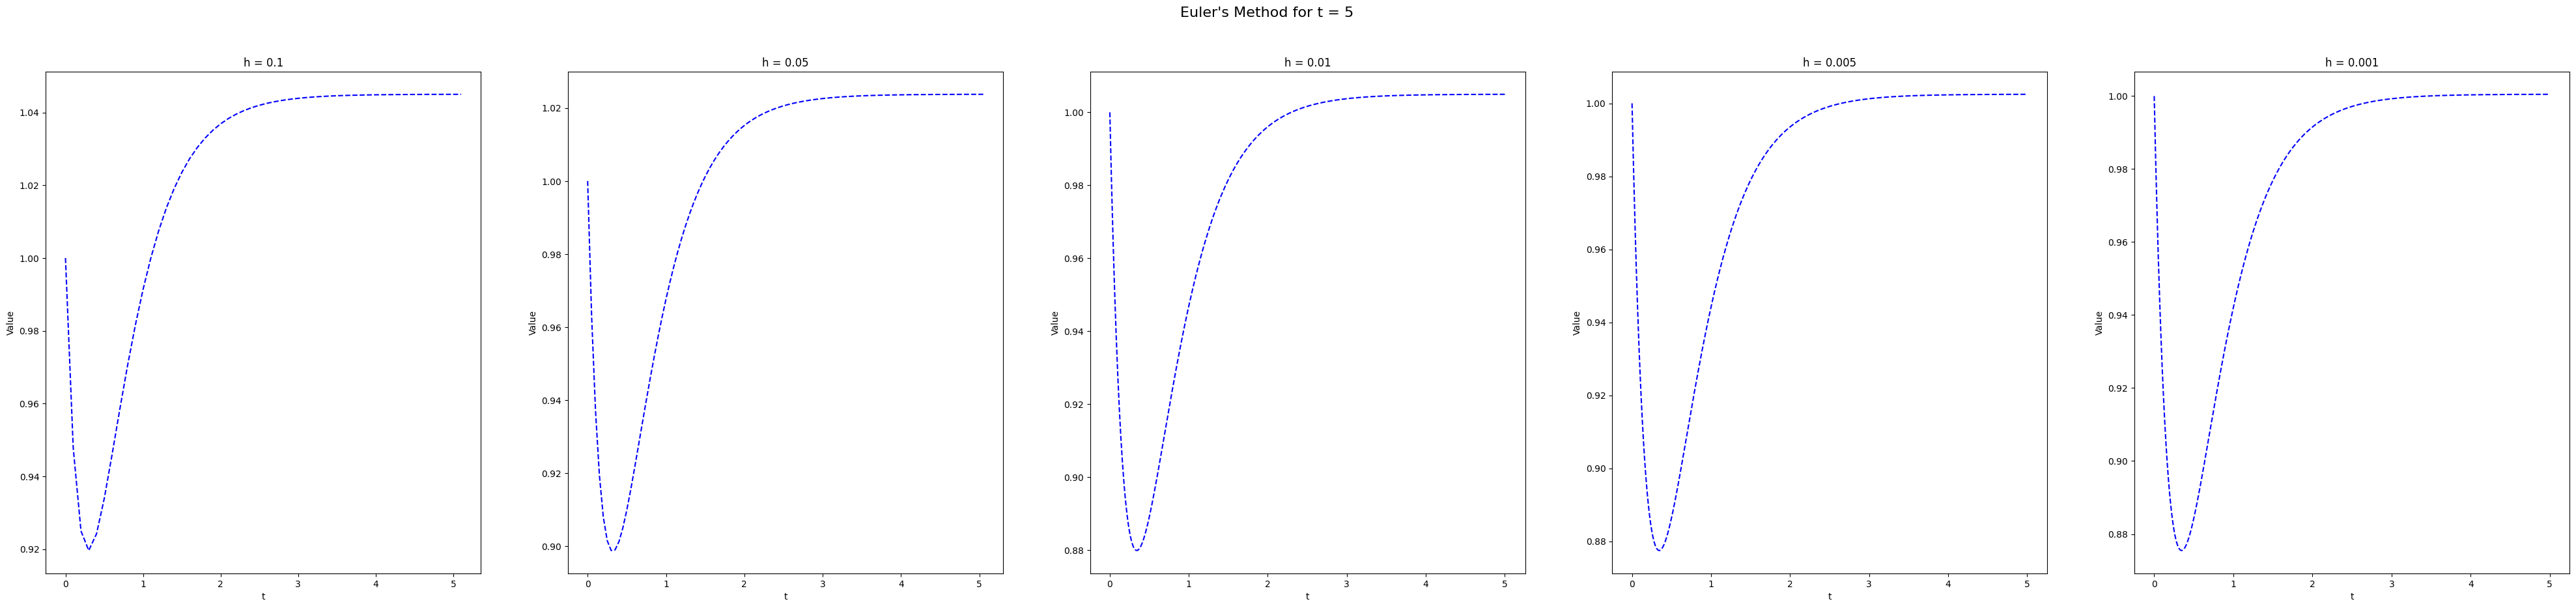

In [67]:
# loop through each target value
for t_value in t_list:
  plot_t(h_values = h_values, t = t_value)

# **Problem 2: Geodesic Shooting Equation**

### Read and visualize data

In [68]:
# All paths are relative. please change the current directory as per your file tree.

# Read in data as a 2, 100, 100 vector field'''
velocity= torch.load('v0.pt').numpy()
print("Dimension of velocity V0: ", velocity.shape)

# Read in data as a 1, 100, 100  image
source= torch.load('source.pt').numpy()
print("Dimension of image: ", source.shape)

Dimension of velocity V0:  (2, 100, 100)
Dimension of image:  (100, 100)


<ipython-input-68-e506a0c0198e>:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  velocity= torch.load('v0.pt').numpy()
<ipython-input-68-e506a0c0198e>:8: FutureWarning: You 

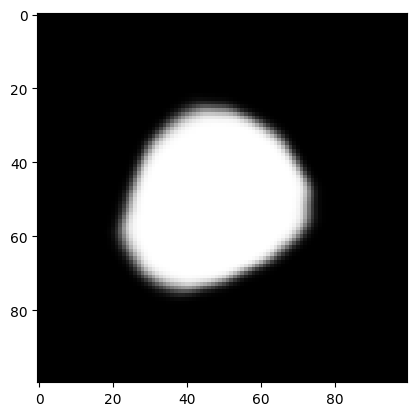

In [69]:
plt.imshow(source, cmap='gray')

### Gradient computation

In [70]:
def forward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,0:cols-2];
    d[:,0] = image[:,0] - image[:,cols-1];
    return d


def forward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1,:] = image[1:rows-1,:] - image[0:rows-2,:];
    d[0,:] = image[0,:] - image[rows-1,:];
    return d

def backward_difference_x(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[:,1:cols-1] = image[:,1:cols-1] - image[:,2:cols]
    d[:,-1] = image[:,-1] - image[:,0]
    return d

def backward_difference_y(image):
    rows, cols = image.shape
    d = np.zeros((rows,cols))
    d[1:rows-1,:] = image[1:rows-1,:] - image[2:rows,:]
    d[-1,:] = image[-1,:] - image[0,:]
    return d

def central_difference_x(image):
    cdif=(forward_difference_x(image)+backward_difference_x(image))/2
    return cdif

def central_difference_y(image):
    cdif=(forward_difference_y(image)+backward_difference_y(image))/2
    return cdif

Grab the initial $\phi$.

In [71]:
# grab the size of the source
source_shape = source.shape
shape_x = source_shape[0]
shape_y = source_shape[1]

x_value = np.linspace(start = 0, stop = 99, num = shape_x)
y_value = np.linspace(start = 0, stop = 99, num = shape_y)

In [72]:
# grab the meshgrid
phi_x, phi_y = np.meshgrid(x_value, y_value)

## **a)**



In [73]:
"""
Calculate the jacobian matrix
@parameters
  v: np.ndarray
    the matrix
@returns
  dxx (np.ndarray)
    gradient of vx along x-direction
  dxy (np.ndarray)
    gradient of vx along y-direction
  dyx (np.ndarray)
    gradient of vy along x-direction
  dyy (np.ndarray)
    gradient of vy along y-direction
"""
def get_jacobian_matrix(v, negative = False):
  # separate into just x coordinates and y coordinates
  vx = v[0]
  vy = v[1]

  output = {}

  # use central difference to calculate gradients
  if not negative:
    output["dxx"] = central_difference_x(vx)
    output["dxy"] = central_difference_y(vx)
    output["dyx"] = central_difference_x(vy)
    output["dyy"] = central_difference_y(vy)
  else:
    output["dxx"] = -central_difference_x(vx)
    output["dxy"] = -central_difference_y(vx)
    output["dyx"] = -central_difference_x(vy)
    output["dyy"] = -central_difference_y(vy)

  return output

# test
jacobian_dict = get_jacobian_matrix(velocity)

In [74]:
"""
This function grabs forms the dv with index
"""
def grab_dv_index(jacobian_dict, row, col):
  dv = np.array([[jacobian_dict["dxx"][row][col], jacobian_dict["dxy"][row][col]],
   [jacobian_dict["dyx"][row][col], jacobian_dict["dyy"][row][col]]])

  return dv

"""
This function grabs the vector
"""
def create_vector(v, row, col):
  vx = v[0]
  vy = v[1]

  return np.array([[vx[row][col]], [vy[row][col]]])


In [75]:
"""
Calculates the dv v term
"""
def dvT_v_computation(v, jacobian_dict):
  # split into x and y coordinates
  vx = v[0]
  vy = v[1]

  # shape of the dxx vector
  x_shape = jacobian_dict["dxx"].shape[0]
  y_shape = jacobian_dict["dxx"].shape[1]

  output = [] # empty output
  output_x_all = []
  output_y_all = []

  # calculate dv.T . vt term
  for row in range(x_shape):
    output_x = []
    output_y = []

    for col in range(y_shape):
      # create arrays
      dv = grab_dv_index(jacobian_dict = jacobian_dict, row = row, col = col)
      vec = create_vector(v, row, col)

      # calculate dv transpose with vector
      dvtv = np.matmul(dv.T, vec)

      output_x.append(dvtv[0][0])
      output_y.append(dvtv[1][0])

    # add to x and y
    output_x_all.append(output_x)
    output_y_all.append(output_y)

  output.append(output_x_all)
  output.append(output_y_all)

  return np.array(output)

In [76]:
"""
Same as above function except without the transpose
"""
def dv_v_computation(v, jacobian_dict):
  # calculate jacobian matrix
  vx = v[0]
  vy = v[1]

  x_shape = jacobian_dict["dxx"].shape[0]
  y_shape = jacobian_dict["dxx"].shape[1]

  output = [] # empty output
  output_x_all = []
  output_y_all = []

  # calculate dv.T . vt term
  for row in range(x_shape):
    output_x = []
    output_y = []

    for col in range(y_shape):
      # create arrays
      dv = grab_dv_index(jacobian_dict, row, col)
      vec = create_vector(v, row, col)

      # calculate dv transpose with vector
      dvv = np.matmul(dv, vec)
      output_x.append(dvv[0][0])
      output_y.append(dvv[1][0])

    output_x_all.append(output_x)
    output_y_all.append(output_y)

  output.append(output_x_all)
  output.append(output_y_all)

  return np.array(output)



In [77]:
# test
dvT_v = dvT_v_computation(velocity, jacobian_dict)
dv_v = dv_v_computation(velocity, jacobian_dict)

In [78]:
"""
This function calculates divergence
"""
def divergence(jacobian_dict):

  return np.add(jacobian_dict["dxx"], jacobian_dict["dyy"])

# test
print(velocity)
print(divergence(jacobian_dict))

[[[-9.4003044e-05 -3.5812240e-04 -5.6039914e-04 ...  5.8996887e-04
    4.2606867e-04  1.8378929e-04]
  [-3.6941655e-04 -6.0262717e-04 -7.0049055e-04 ...  6.1395532e-04
    3.0812068e-04 -4.4303772e-05]
  [-5.4466445e-04 -7.1387691e-04 -7.0426287e-04 ...  5.4023485e-04
    1.6193883e-04 -2.2976636e-04]
  ...
  [ 6.5645762e-04  5.2524731e-04  2.3726607e-04 ...  7.8074168e-05
    3.9256271e-04  6.0536945e-04]
  [ 4.8690103e-04  2.7632108e-04 -3.6826008e-05 ...  2.9675988e-04
    4.8194686e-04  5.5605918e-04]
  [ 2.1577440e-04 -4.0871091e-05 -3.2152236e-04 ...  4.7718803e-04
    4.9045635e-04  4.0176744e-04]]

 [[-4.6192482e-04 -8.7574450e-04 -1.0780443e-03 ...  9.8155206e-04
    5.8787270e-04  6.6690613e-05]
  [ 1.4752429e-04 -2.1350756e-04 -5.2028010e-04 ...  7.6414086e-04
    7.0007518e-04  4.7761155e-04]
  [ 7.0806872e-04  4.8646703e-04  1.5213713e-04 ...  3.6540534e-04
    6.3959975e-04  7.6362304e-04]
  ...
  [-1.1894247e-03 -1.3223113e-03 -1.1410262e-03 ...  4.9788971e-04
   -1.6082

In [79]:
def v_div_calculation(v, jacobian_dict):
  vx = v[0]
  vy = v[1]

  rows = vx.shape[0]
  cols = vx.shape[1]

  div_v = divergence(jacobian_dict)

  for row in range(rows):

    for col in range(cols):

      vx[row][col] = vx[row][col] * div_v[row][col]
      vy[row][col] = vy[row][col] * div_v[row][col]

  return np.array([vx, vy])

# test
print(v_div_calculation(velocity, jacobian_dict))

[[[-1.06817160e-08 -7.32358814e-08 -6.27891907e-08 ...  2.88835231e-08
    6.63142217e-08  6.40565361e-08]
  [ 5.10179206e-08  5.21528314e-08  9.28429387e-08 ...  9.10627591e-08
    3.37804629e-08 -9.96884086e-09]
  [ 3.47781999e-08  2.04409698e-08  5.01686586e-08 ...  5.89091265e-08
    1.58379265e-08 -6.01990067e-08]
  ...
  [-8.79534596e-08 -4.42119727e-08 -1.95691303e-08 ...  3.23165894e-09
    6.20336060e-10 -8.72768311e-08]
  [-9.34332789e-08 -3.47844740e-08  5.10105602e-09 ...  2.86033970e-08
    1.79449149e-08 -3.63444101e-08]
  [-7.45552953e-08  9.13133746e-09  5.80512847e-08 ...  2.33524222e-08
   -3.21120908e-08 -4.68620627e-08]]

 [[-5.24892556e-08 -1.79089383e-07 -1.20788059e-07 ...  4.80545381e-08
    9.14977463e-08  2.32438424e-08]
  [-2.03737009e-08  1.84774684e-08  6.89578670e-08 ...  1.13338494e-07
    7.67519523e-08  1.07467905e-07]
  [-4.52119764e-08 -1.39293732e-08 -1.08375948e-08 ...  3.98450979e-08
    6.25540792e-08  2.00069962e-07]
  ...
  [ 1.59361406e-07  1.1

In [80]:
"""
Solve the velocities
"""
def calculate_velocities(v, t, sigma = 2.0):
  h = t[1] - t[0] # get the step value

  velocities_list = []
  velocities_list.append(v)
  vx = v[0]
  vy = v[1]

  v_t = v.copy()

  # loop through time cycles
  for idx in range(1, len(t)):
    """
    calculate the velocity portion
    """

    # calculate components
    jacobian_dict = get_jacobian_matrix(v = v_t) # jacobian matrix

    dvT_v = dvT_v_computation(v = v_t, jacobian_dict = jacobian_dict) # dv_t_v computation
    dv_v = dv_v_computation(v = v_t, jacobian_dict = jacobian_dict) # dv_v computation
    v_div = v_div_calculation(v = v_t, jacobian_dict = jacobian_dict)

    # calculate value without bayesian approach
    compute = np.add(np.add(dvT_v, dv_v), v_div)

    gaussian_smooth_x = -sp.ndimage.gaussian_filter(compute[0], sigma = sigma)
    gaussian_smooth_y = -sp.ndimage.gaussian_filter(compute[1], sigma = sigma)

    # euler's method for v
    vx = np.add(vx, h * gaussian_smooth_x)
    vy = np.add(vy, h * gaussian_smooth_y)

    v_t[0] = vx
    v_t[1] = vy

    velocities_list.append(np.array(v_t))

  return velocities_list

# testing
test = calculate_velocities(velocity, t = [0, .1])
# velocity does not change

In [81]:
"""
Calculate phi list using velocities
"""
def calculate_image_sequence(source, velocities, phi_x, phi_y, t_list):
  image_list = []
  image_list.append(source)
  h = t_list[1] - t_list[0]

  for i in range(1, len(velocities)): # loop through velocities
    v = velocities[i]

    # dphi = np.array(sp.ndimage.map_coordinates([v[0].flatten(), v[1].flatten()], [phi_x, phi_y])) # 100 x 100
    dphi_x = np.array(sp.ndimage.map_coordinates(v[0], [phi_y, phi_x]))
    dphi_y = np.array(sp.ndimage.map_coordinates(v[1], [phi_y, phi_x]))

    phi_x = np.add(phi_x, h * dphi_x)
    phi_y = np.add(phi_y, h * dphi_y)

    # show deformed image
    deformed_img = sp.ndimage.map_coordinates(source, [phi_y, phi_x])

    image_list.append(deformed_img)

  return image_list

# velocity does not change

In [82]:
def convert_to_coordinates(x, y):
  output = []

  for row in range(x.shape[0]):
    output_row = []
    for col in range(x.shape[1]):
      output_row.append([x[row][col], y[row][col]])

  output.append(output_row)

  return np.array(output)

"""
This function finds dv/dt
"""
def compute_geodesic_shooting_equations(source, phi_x, phi_y, v, t):

  # start timer
  start = time.time()

  velocities = calculate_velocities(v, t)
  image_list = calculate_image_sequence(source, velocities, phi_x, phi_y, t)

  end = time.time()
  return {
      "velocities": velocities,
      "images": image_list,
      "time_elapsed": (end - start),
      "t": t
  }

# no change

In [83]:
t = [0, .1, .2, .3, .4, .5, .6, .7, .8, .9, 1]

lddmm_report = compute_geodesic_shooting_equations(source, phi_x, phi_y, v = velocity, t = t)

# for v in velocities:
#   print(f"\n\n{v}")

In [142]:
def display_image_with_difference(img_name, img):
  print("\n")
  print(f"======= {img_name} =======")
  plt.imshow(img, cmap = "gray")
  plt.show()
  print("\n")
  print(f"shape: {img.shape}")


In [143]:
"""
Prints the velocity as an RGB image
"""

def display_velocity(velocity, channel_shape = (100, 100)):
  velocity_img = []

  v_x = velocity[0]
  v_y = velocity[1]
  v_z = np.zeros(shape = channel_shape)

  for i in range(channel_shape[0]): # outer loop
    outer_list = []

    for j in range(channel_shape[1]): # inner loop
      outer_list.append([v_x[i][j], v_y[i][j], v_z[i][j]])

    velocity_img.append(outer_list)

  imgplot = plt.imshow(velocity_img)
  plt.show()

#test
# display_velocity(velocity)

## **b)**




======= t = 0 =======


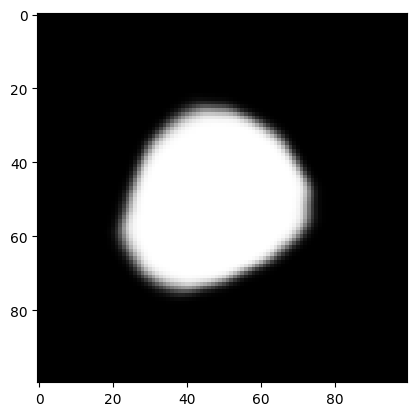



shape: (100, 100)


======= t = 0.1 =======


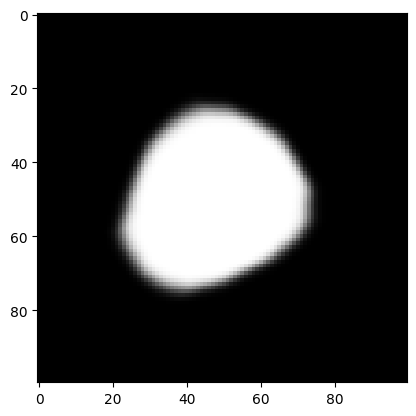



shape: (100, 100)
Numerical Difference: 1.2236511707305908


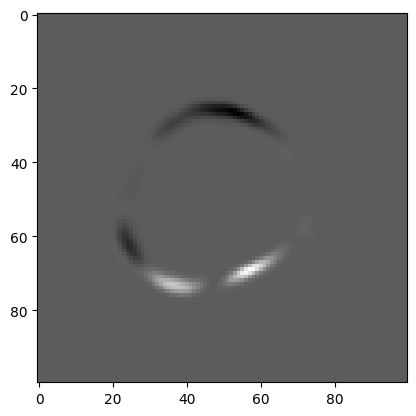



======= t = 0.2 =======


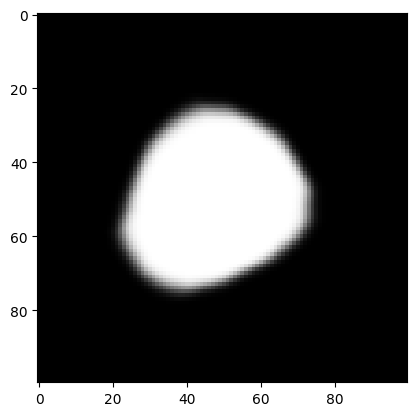



shape: (100, 100)
Numerical Difference: 1.2201284170150757


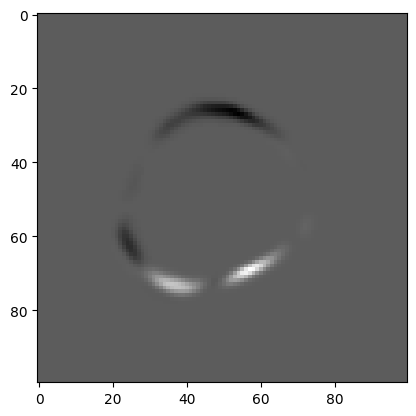



======= t = 0.3 =======


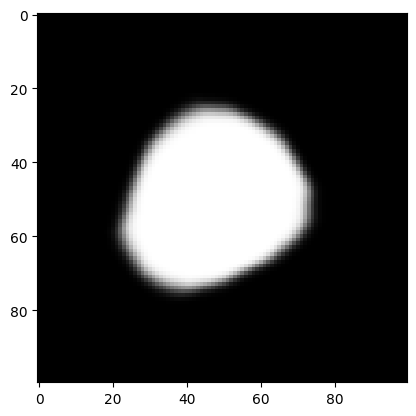



shape: (100, 100)
Numerical Difference: 1.2165913581848145


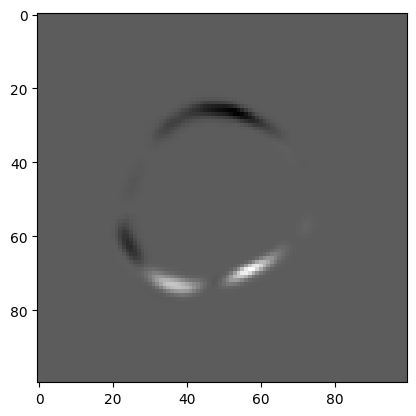



======= t = 0.4 =======


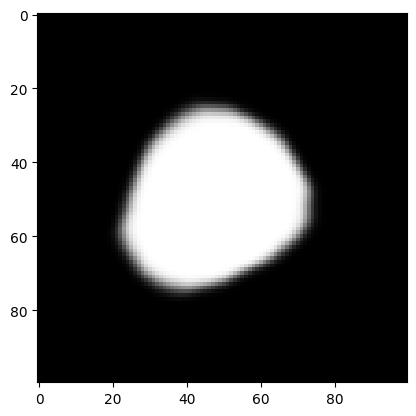



shape: (100, 100)
Numerical Difference: 1.213044285774231


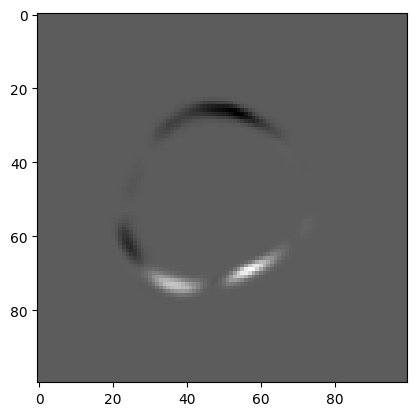



======= t = 0.5 =======


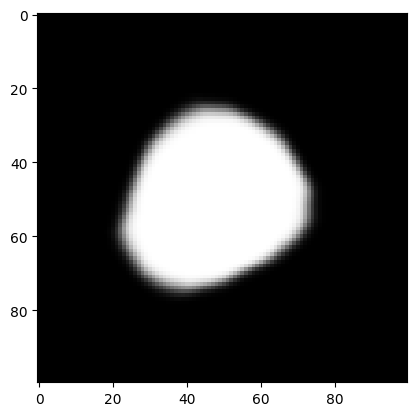



shape: (100, 100)
Numerical Difference: 1.2094850540161133


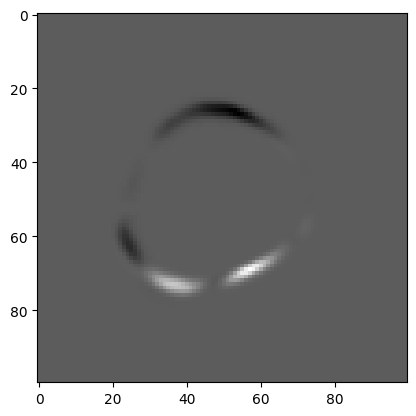



======= t = 0.6 =======


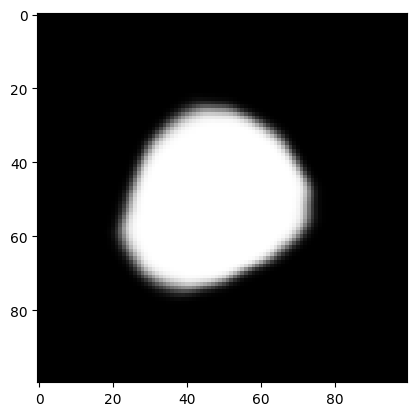



shape: (100, 100)
Numerical Difference: 1.2059177160263062


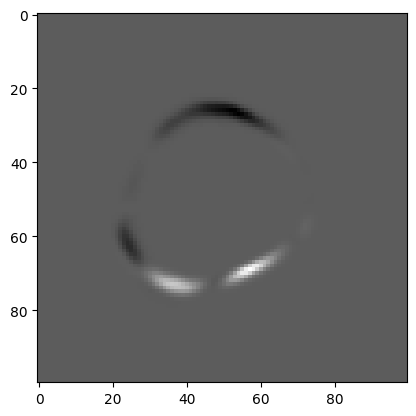



======= t = 0.7 =======


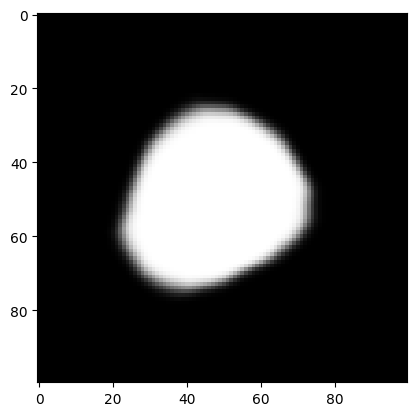



shape: (100, 100)
Numerical Difference: 1.202341914176941


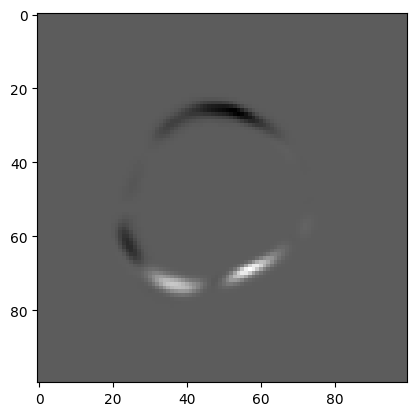



======= t = 0.8 =======


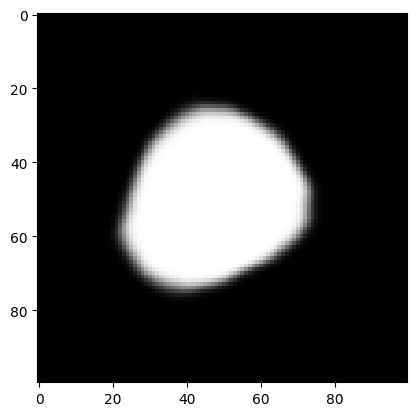



shape: (100, 100)
Numerical Difference: 1.1987570524215698


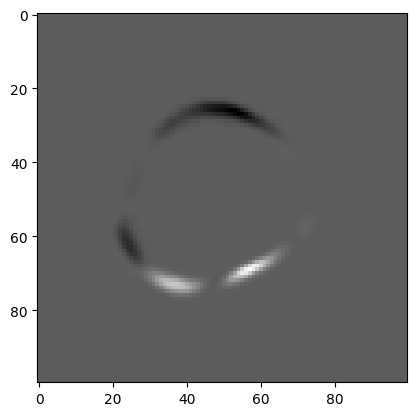



======= t = 0.9 =======


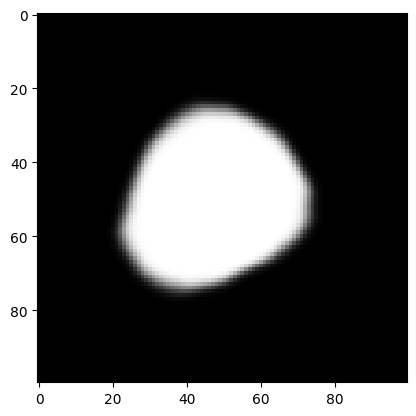



shape: (100, 100)
Numerical Difference: 1.1951628923416138


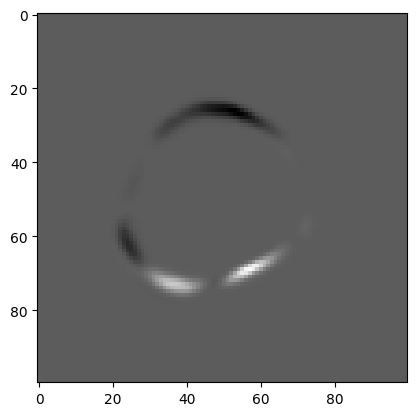



======= t = 1 =======


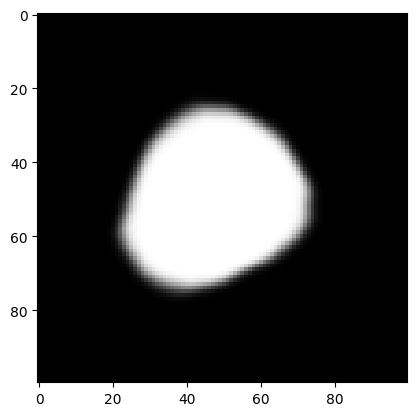



shape: (100, 100)
Numerical Difference: 1.1915631294250488


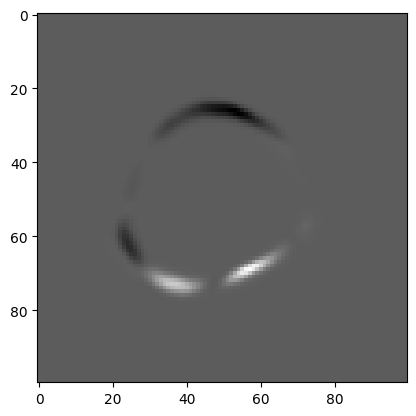

[[[-1.06817284e-08 -7.32358956e-08 -6.27892049e-08 ...  2.88835107e-08
    6.63142075e-08  6.40565290e-08]
  [ 5.10179099e-08  5.21528207e-08  9.28429316e-08 ...  9.10627449e-08
    3.37804522e-08 -9.96884975e-09]
  [ 3.47781928e-08  2.04409627e-08  5.01686515e-08 ...  5.89091194e-08
    1.58379194e-08 -6.01990138e-08]
  ...
  [-8.79534667e-08 -4.42119799e-08 -1.95691356e-08 ...  3.23165539e-09
    6.20334062e-10 -8.72768311e-08]
  [-9.34332860e-08 -3.47844811e-08  5.10104892e-09 ...  2.86033917e-08
    1.79449131e-08 -3.63444101e-08]
  [-7.45553095e-08  9.13132681e-09  5.80512776e-08 ...  2.33524169e-08
   -3.21120943e-08 -4.68620627e-08]]

 [[-5.24892876e-08 -1.79089412e-07 -1.20788087e-07 ...  4.80545168e-08
    9.14977321e-08  2.32438300e-08]
  [-2.03737258e-08  1.84774436e-08  6.89578457e-08 ...  1.13338473e-07
    7.67519381e-08  1.07467891e-07]
  [-4.52119941e-08 -1.39293910e-08 -1.08376108e-08 ...  3.98450837e-08
    6.25540650e-08  2.00069948e-07]
  ...
  [ 1.59361377e-07  1.1

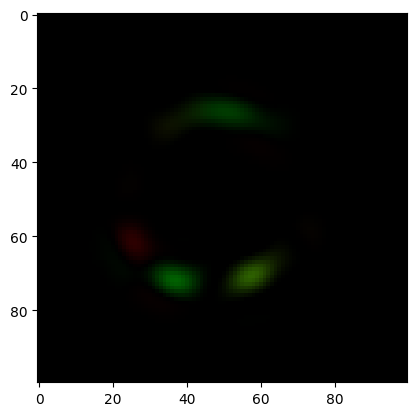

In [148]:
final_velocity = lddmm_report["velocities"][-1]

# images
for i in range(len(lddmm_report["images"])):
  display_image_with_difference(f"t = {t[i]}", lddmm_report["images"][i])

  if i > 0:
    diff = lddmm_report["images"][i-1] - lddmm_report["images"][i]
    print(f"Numerical Difference: {np.sum(np.abs(diff))}")
    plt.imshow(diff, cmap = "gray")

    plt.show()

# velocity
print(final_velocity)
display_velocity(final_velocity)

## **c)**

In [145]:
time_val = lddmm_report["time_elapsed"]
print(f"Running Time: {time_val}s")

Running Time: 2.4001715183258057s


## **d)**

In [87]:
"""
This function initializes the original vector field
"""
def init_vector_field(source, shape = (100, 100), sigma = 2.0):
  # initialize random normal to calculate epsilon
  vx = np.random.normal(scale = sigma, size = shape)
  vy = np.random.normal(scale = sigma, size = shape)

  # smooth epsilon
  gaussian_smooth_x = sp.ndimage.gaussian_filter(vx, sigma = sigma)
  gaussian_smooth_y = sp.ndimage.gaussian_filter(vy, sigma = sigma)

  # get the gradients of the source image
  sx = central_difference_x(source)
  sy = central_difference_y(source)

  # matrix multiply
  v0_x = np.matmul(gaussian_smooth_x, sx)
  v0_y = np.matmul(gaussian_smooth_y, sy)

  return np.array([v0_x, v0_y])

# test
print(init_vector_field(source).shape)

(2, 100, 100)






======= t = 0 =======


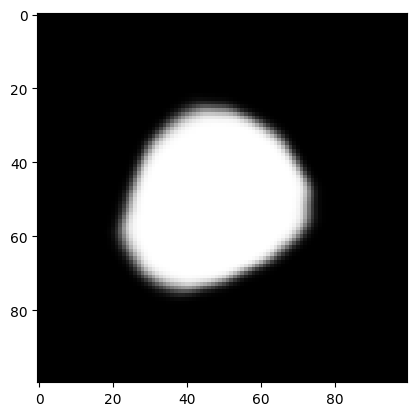



shape: (100, 100)


======= t = 0.1 =======


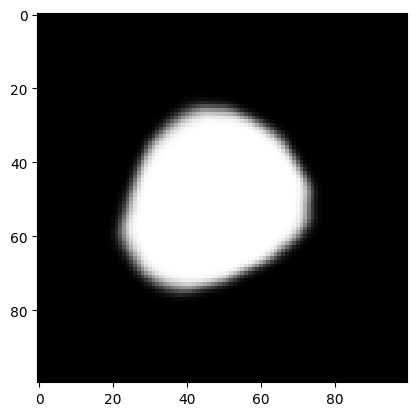



shape: (100, 100)
Numerical Difference: 1.0728654861450195


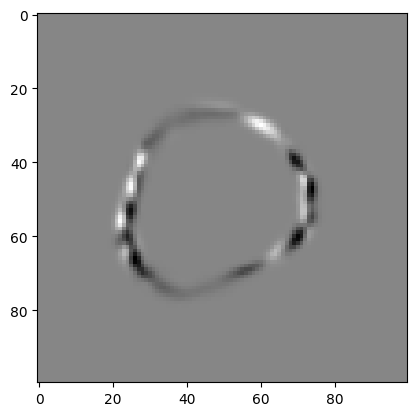



======= t = 0.2 =======


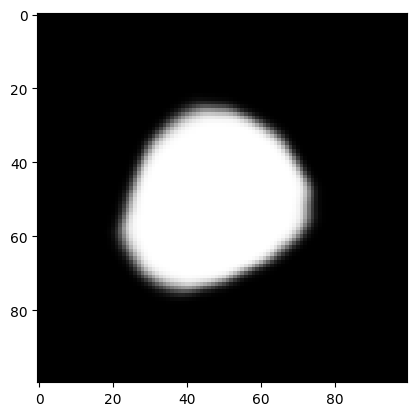



shape: (100, 100)
Numerical Difference: 1.0726990699768066


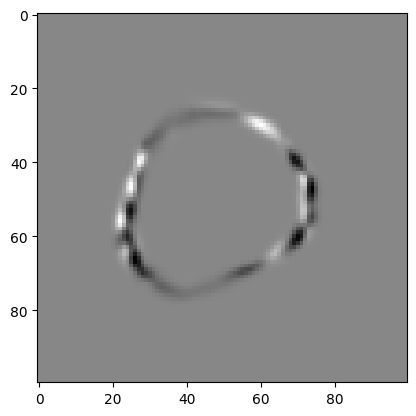



======= t = 0.3 =======


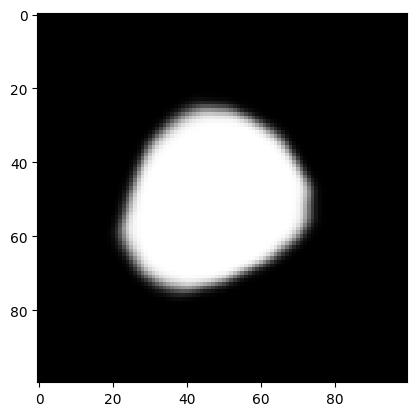



shape: (100, 100)
Numerical Difference: 1.0726242065429688


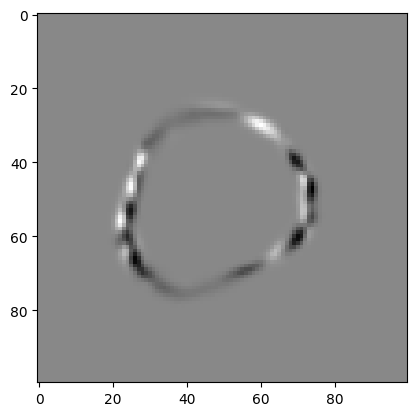



======= t = 0.4 =======


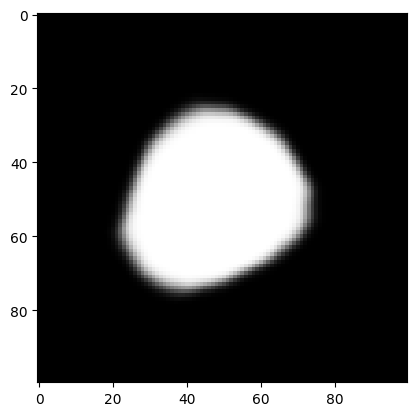



shape: (100, 100)
Numerical Difference: 1.0725781917572021


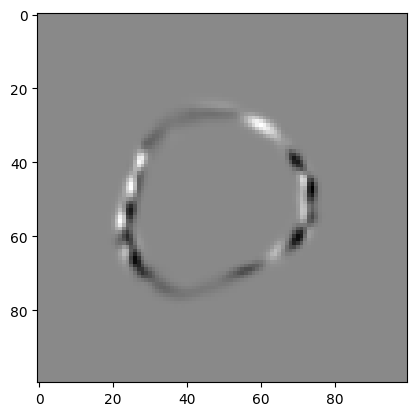



======= t = 0.5 =======


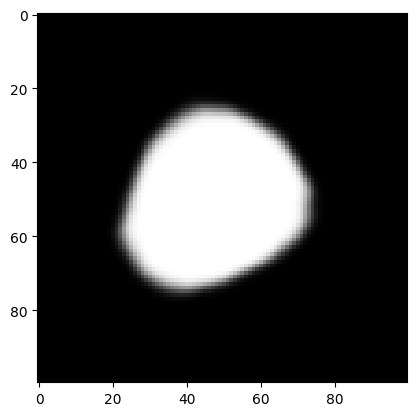



shape: (100, 100)
Numerical Difference: 1.072553277015686


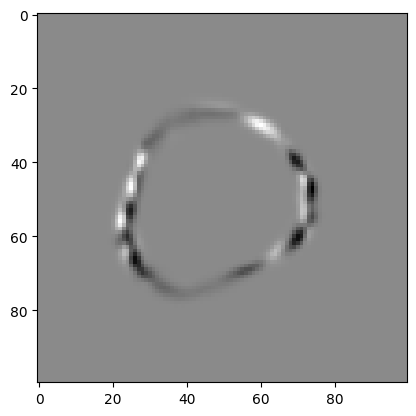



======= t = 0.6 =======


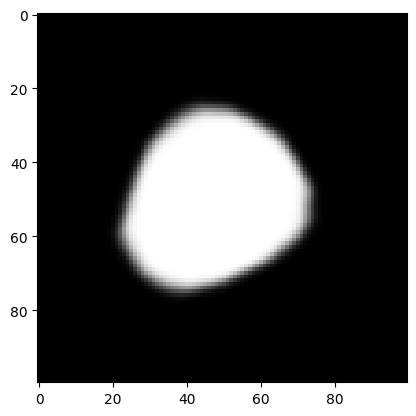



shape: (100, 100)
Numerical Difference: 1.072522759437561


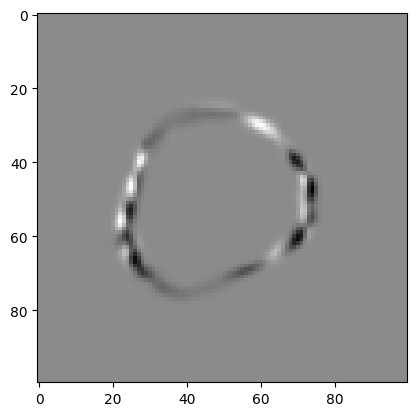



======= t = 0.7 =======


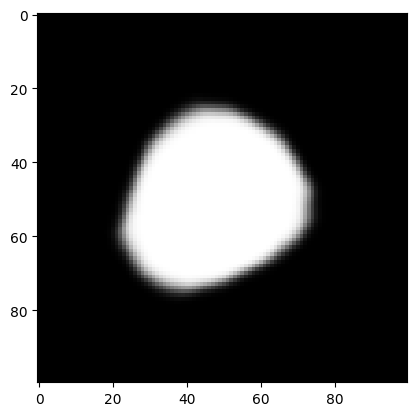



shape: (100, 100)
Numerical Difference: 1.0724825859069824


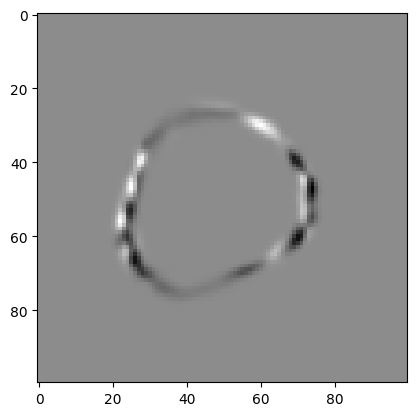



======= t = 0.8 =======


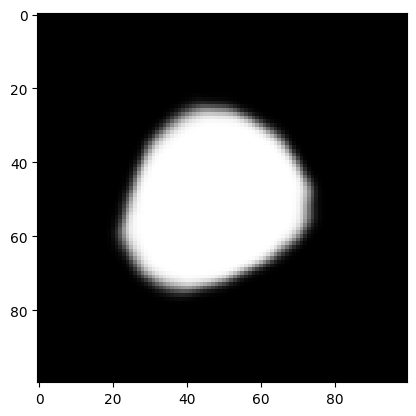



shape: (100, 100)
Numerical Difference: 1.072433352470398


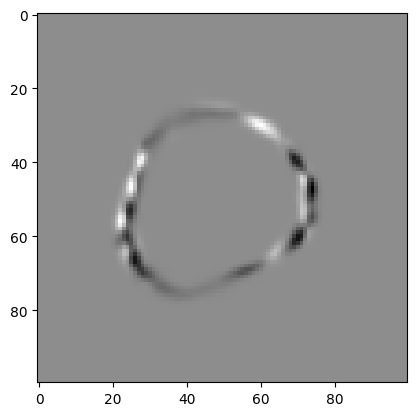



======= t = 0.9 =======


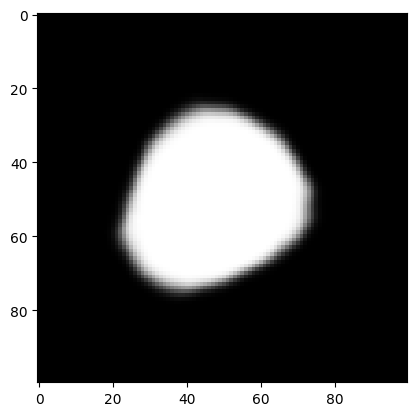



shape: (100, 100)
Numerical Difference: 1.0724409818649292


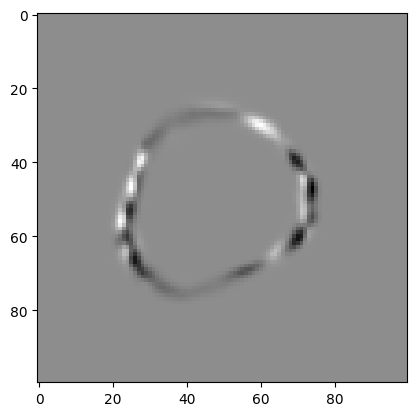



======= t = 1 =======


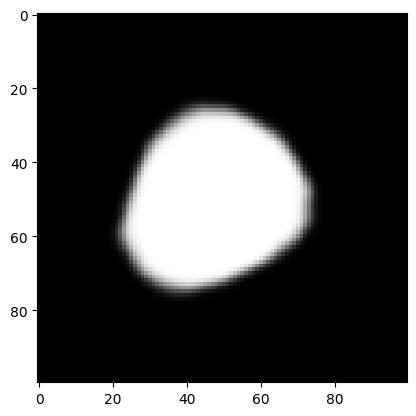



shape: (100, 100)
Numerical Difference: 1.072455644607544


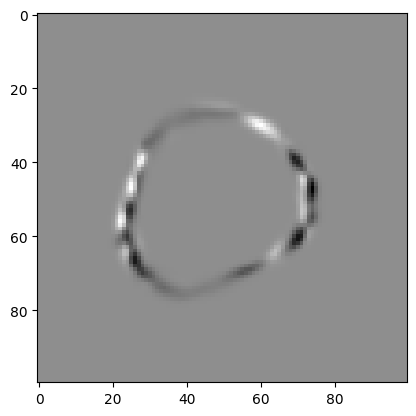

Final Velocity



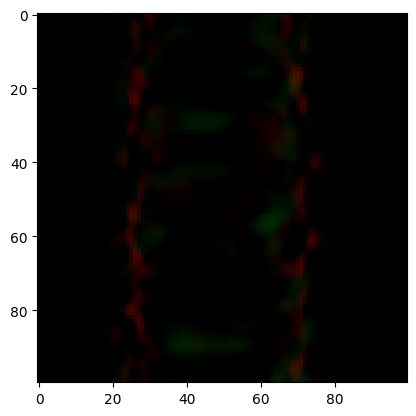





======= t = 0 =======


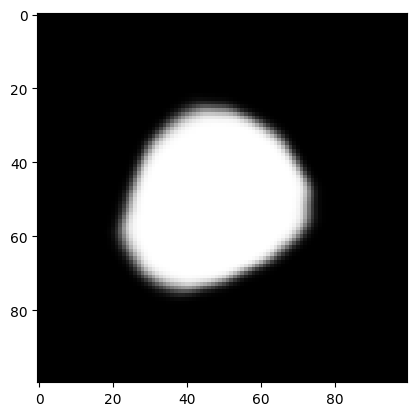



shape: (100, 100)


======= t = 0.1 =======


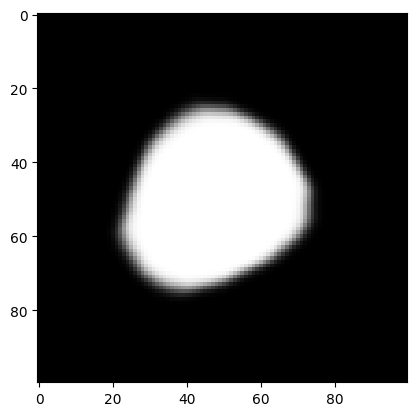



shape: (100, 100)
Numerical Difference: 0.9453316926956177


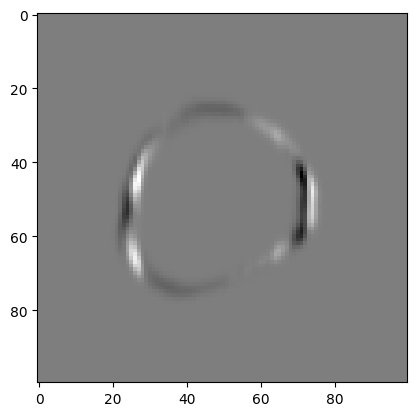



======= t = 0.2 =======


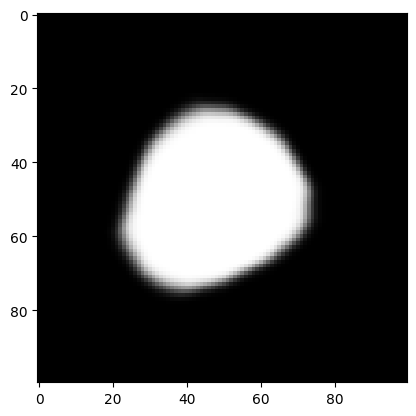



shape: (100, 100)
Numerical Difference: 0.946586012840271


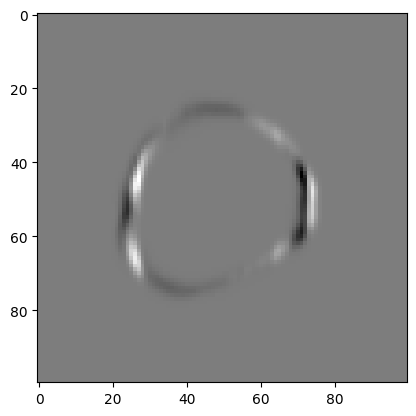



======= t = 0.3 =======


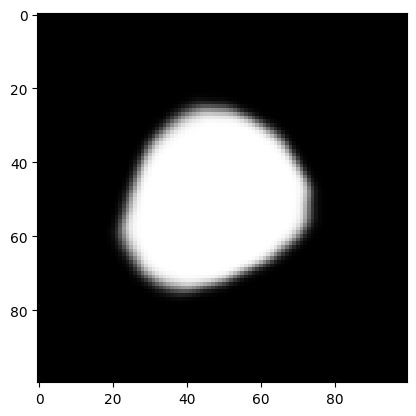



shape: (100, 100)
Numerical Difference: 0.9478005766868591


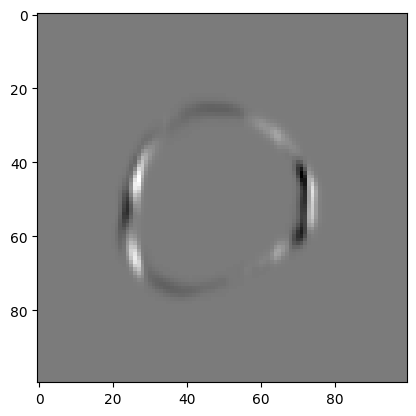



======= t = 0.4 =======


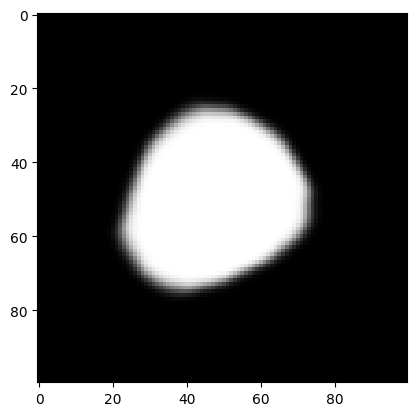



shape: (100, 100)
Numerical Difference: 0.9489753842353821


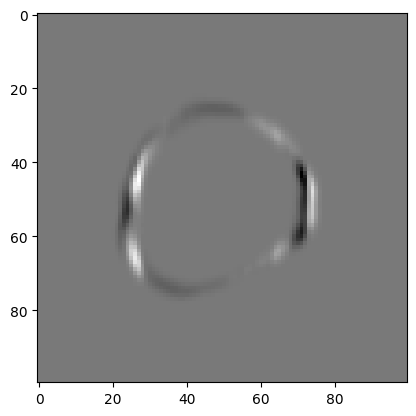



======= t = 0.5 =======


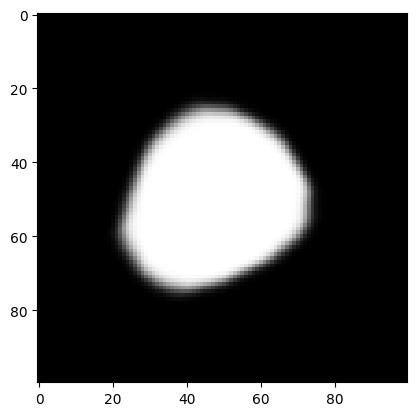



shape: (100, 100)
Numerical Difference: 0.9501058459281921


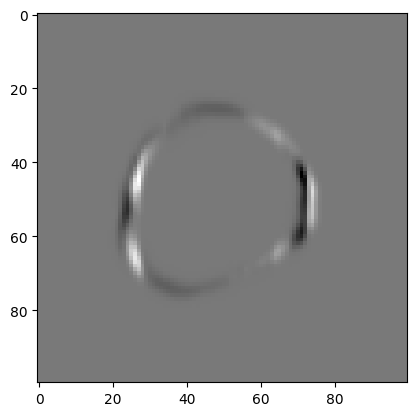



======= t = 0.6 =======


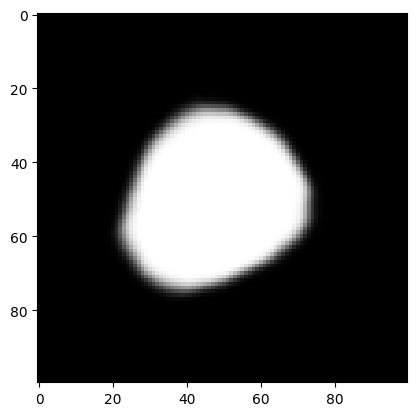



shape: (100, 100)
Numerical Difference: 0.9511957764625549


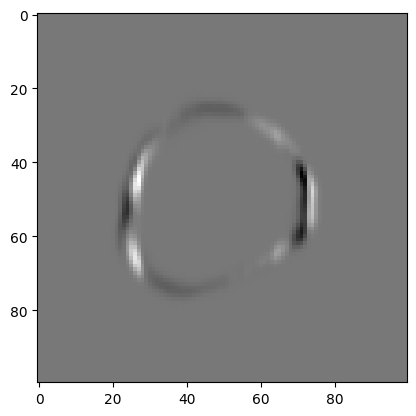



======= t = 0.7 =======


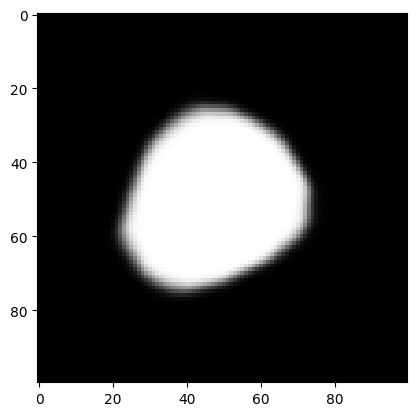



shape: (100, 100)
Numerical Difference: 0.9522375464439392


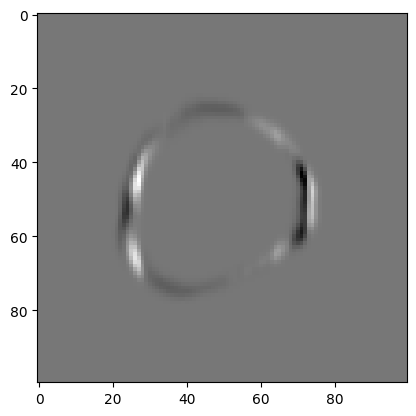



======= t = 0.8 =======


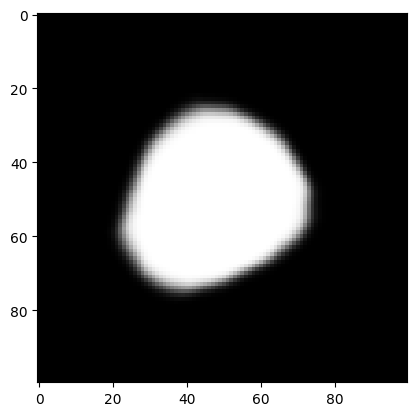



shape: (100, 100)
Numerical Difference: 0.9532339572906494


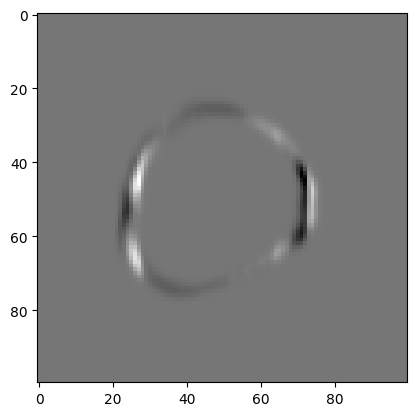



======= t = 0.9 =======


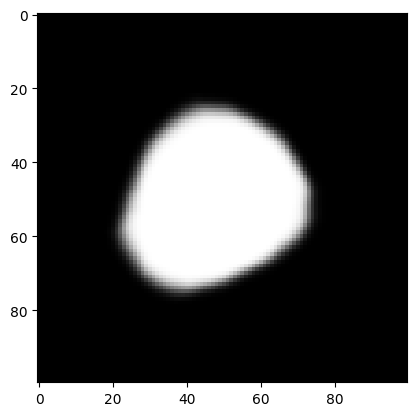



shape: (100, 100)
Numerical Difference: 0.9541813731193542


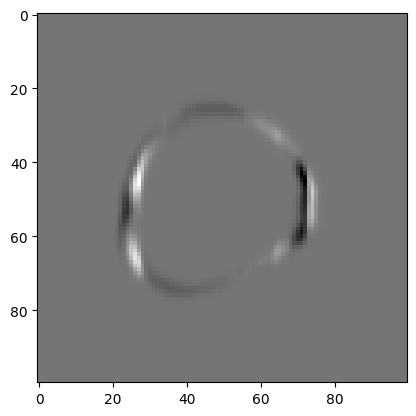



======= t = 1 =======


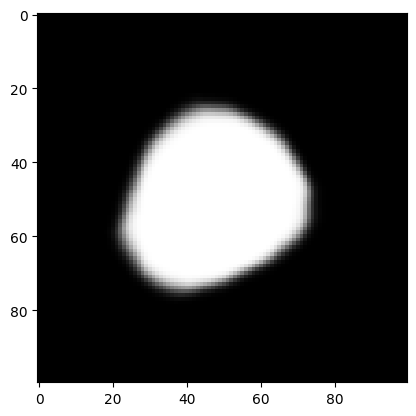



shape: (100, 100)
Numerical Difference: 0.9550781846046448


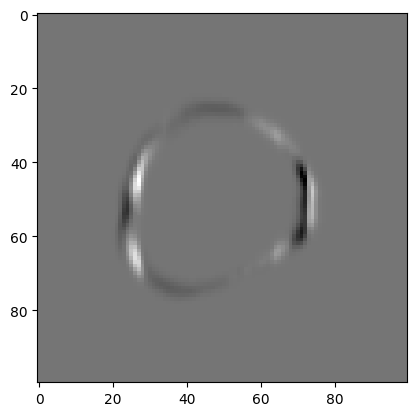

Final Velocity



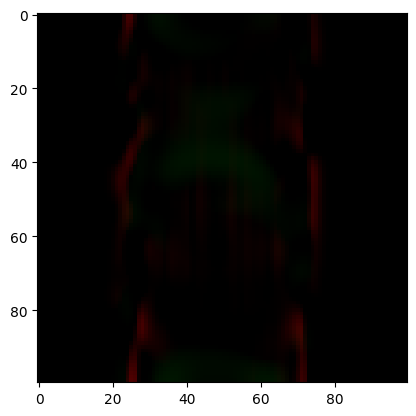





======= t = 0 =======


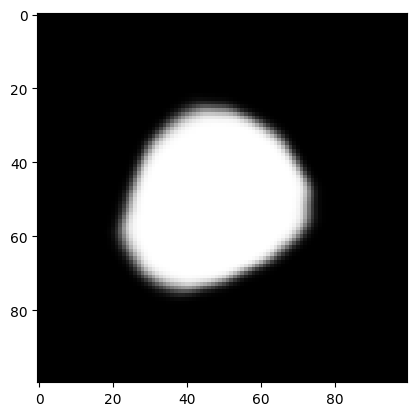



shape: (100, 100)


======= t = 0.1 =======


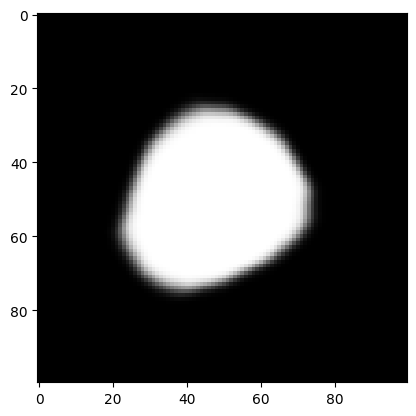



shape: (100, 100)
Numerical Difference: 0.6005716919898987


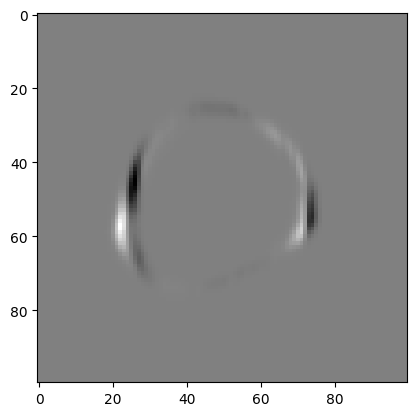



======= t = 0.2 =======


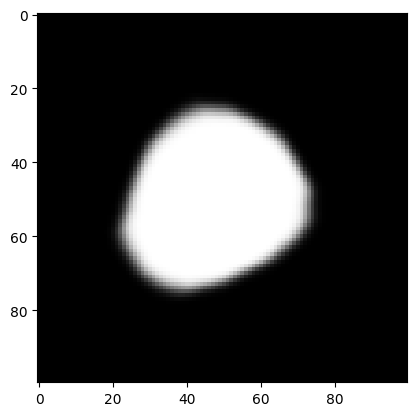



shape: (100, 100)
Numerical Difference: 0.5999181270599365


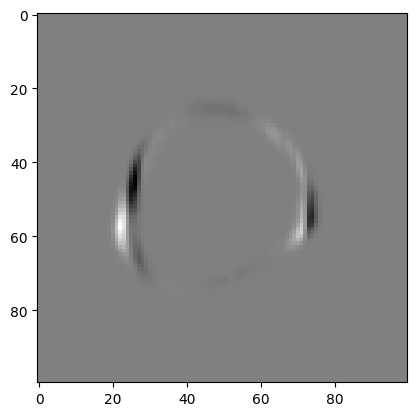



======= t = 0.3 =======


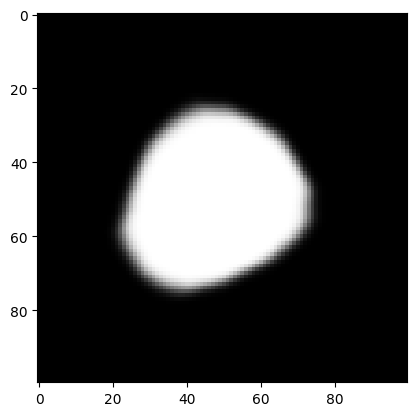



shape: (100, 100)
Numerical Difference: 0.5992457866668701


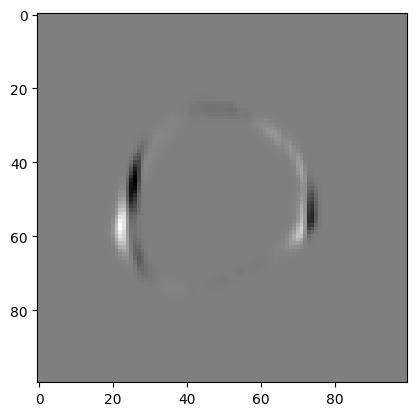



======= t = 0.4 =======


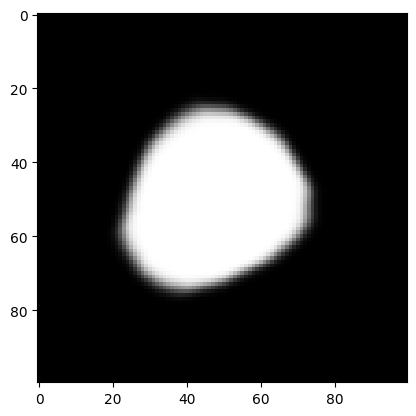



shape: (100, 100)
Numerical Difference: 0.5985572338104248


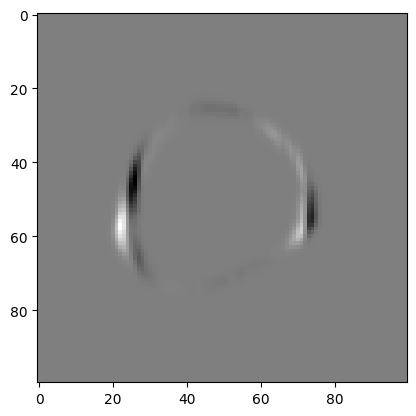



======= t = 0.5 =======


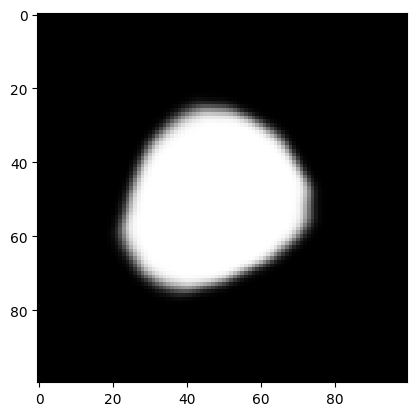



shape: (100, 100)
Numerical Difference: 0.5978636741638184


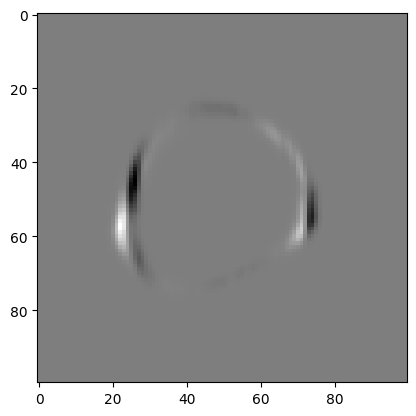



======= t = 0.6 =======


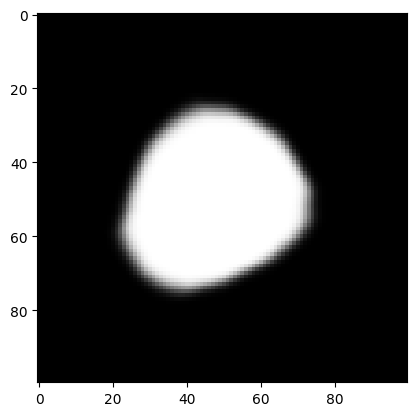



shape: (100, 100)
Numerical Difference: 0.597160816192627


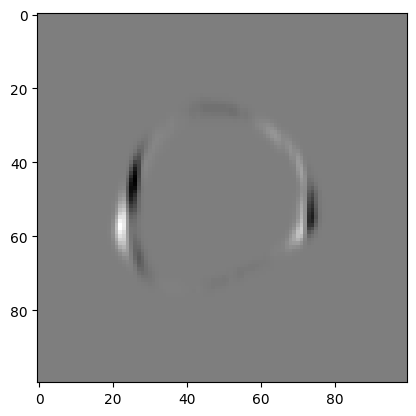



======= t = 0.7 =======


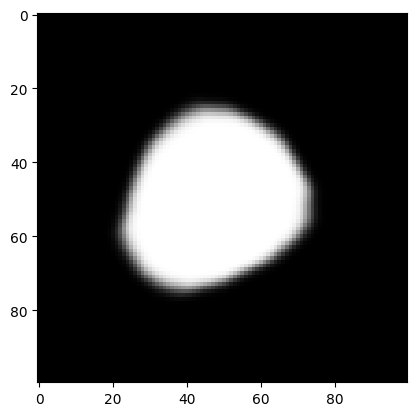



shape: (100, 100)
Numerical Difference: 0.5964516997337341


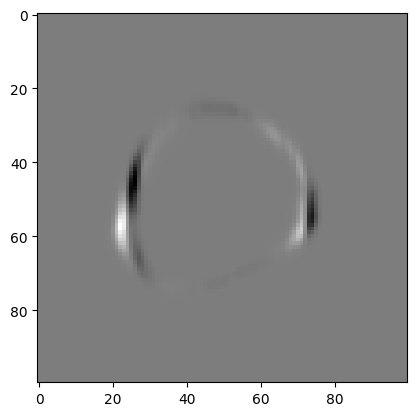



======= t = 0.8 =======


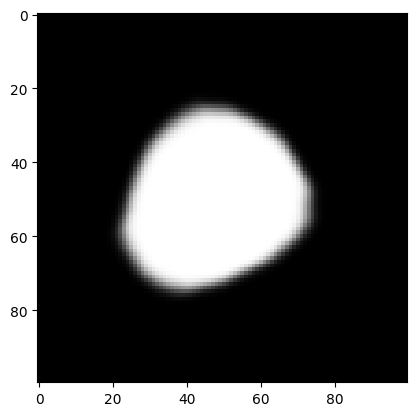



shape: (100, 100)
Numerical Difference: 0.5957401990890503


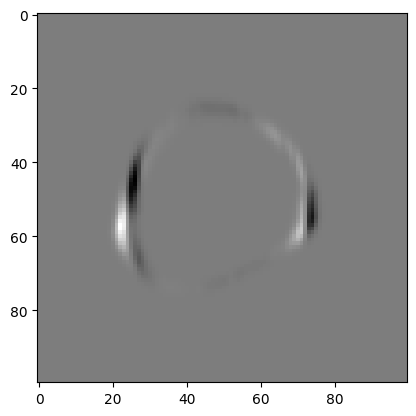



======= t = 0.9 =======


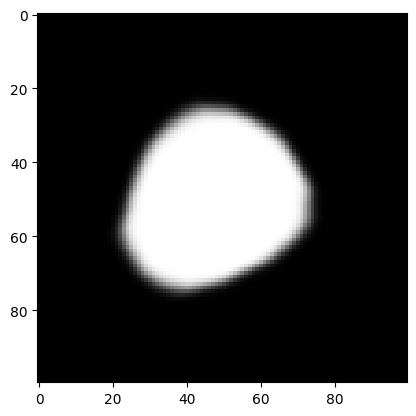



shape: (100, 100)
Numerical Difference: 0.5950249433517456


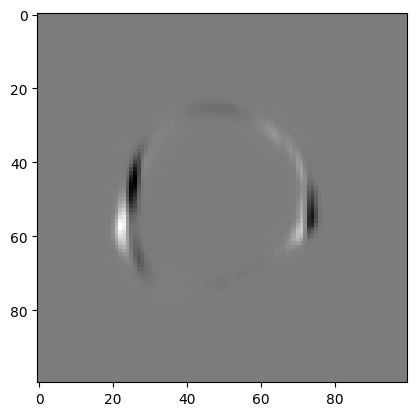



======= t = 1 =======


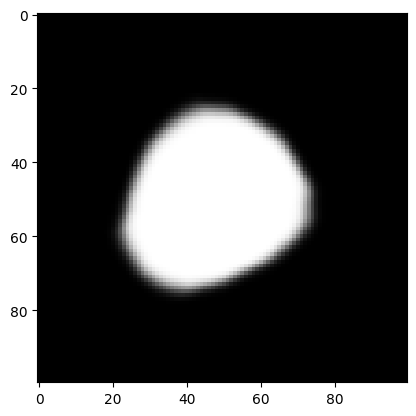



shape: (100, 100)
Numerical Difference: 0.5942997336387634


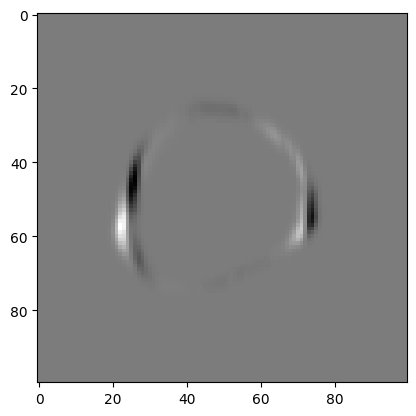

Final Velocity



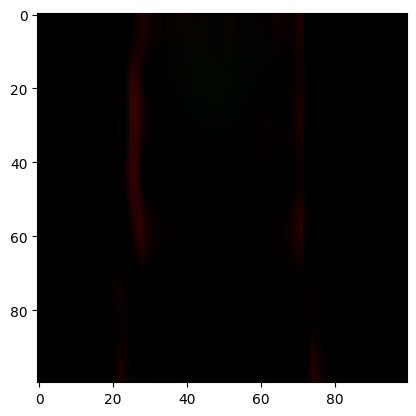

In [150]:
"""
Run the geodesic shooting with an initialized velocity
"""
def geodesic_shooting_init_v(source, phi_x, phi_y, t, shape = (100, 100), sigmas = [.1]):
  for sigma in sigmas:
    v_0 = init_vector_field(source, shape = shape, sigma = sigma) # init velocity

    lddmm_report = compute_geodesic_shooting_equations(source, phi_x, phi_y,
                                                       v_0, t)

    final_velocity = lddmm_report["velocities"][-1]

    # final velocity
    print("\n\n=======================================================")

   # images
    for i in range(len(lddmm_report["images"])):
      display_image_with_difference(f"t = {t[i]}", lddmm_report["images"][i])

      if i > 0:
        diff = lddmm_report["images"][i-1] - lddmm_report["images"][i]
        plt.imshow(diff, cmap = "gray")
        print(f"Numerical Difference: {np.sum(np.abs(diff))}")

      plt.show()

    print(f"Final Velocity\n")
    display_velocity(final_velocity)

geodesic_shooting_init_v(source, phi_x, phi_y, t, sigmas = [2.0, 4.0, 8.0])

# **3)**

In [96]:
"""
Solve the velocities
"""
def calculate_inverse_velocities(v, t, sigma = 2.0):
  h = t[1] - t[0] # get the step value

  velocities_list = []
  velocities_list.append(v)
  vx = v[0]
  vy = v[1]

  v_t = v.copy()

  # loop through time cycles
  for idx in range(1, len(t)):
    """
    calculate the velocity portion
    """

    # calculate components
    jacobian_dict = get_jacobian_matrix(v = v_t) # jacobian matrix

    dvT_v = dvT_v_computation(v = v_t, jacobian_dict = jacobian_dict) # dv_t_v computation
    dv_v = dv_v_computation(v = v_t, jacobian_dict = jacobian_dict) # dv_v computation
    v_div = v_div_calculation(v = v_t, jacobian_dict = jacobian_dict)

    # calculate value without bayesian approach
    compute = np.add(np.add(dvT_v, dv_v), v_div)

    gaussian_smooth_x = sp.ndimage.gaussian_filter(compute[0], sigma = sigma)
    gaussian_smooth_y = sp.ndimage.gaussian_filter(compute[1], sigma = sigma)

    # euler's method for v
    vx = np.add(vx, h * gaussian_smooth_x)
    vy = np.add(vy, h * gaussian_smooth_y)

    v_t[0] = vx
    v_t[1] = vy

    velocities_list.append(np.array(v_t))

  return velocities_list

In [97]:
def calculate_dphi_inverse(jacobian_dict, v):
  output = [] # empty output
  output_x_all = []
  output_y_all = []

  x_shape, y_shape = jacobian_dict["dxx"].shape

  for row in range(x_shape):
    output_x = []
    output_y = []

    for col in range(y_shape):
      # create arrays
      dv = grab_dv_index(jacobian_dict, row, col)
      vec = create_vector(v, row, col)

      # calculate dv transpose with vector
      dvv = np.matmul(-dv, vec)
      output_x.append(dvv[0][0])
      output_y.append(dvv[1][0])

    output_x_all.append(output_x)
    output_y_all.append(output_y)

  output.append(output_x_all)
  output.append(output_y_all)


  return np.array(output)





======= inverse_image =======


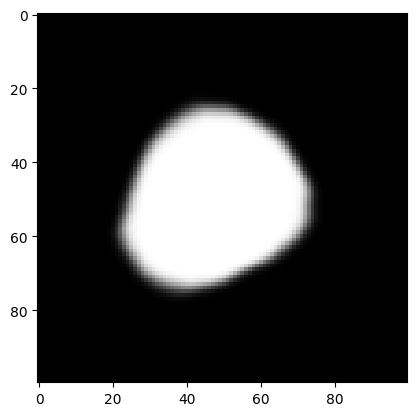



shape: (100, 100)
Final Velocity


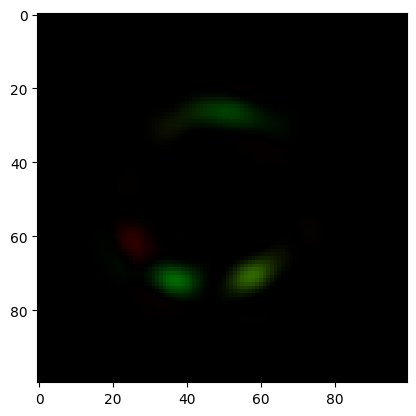

In [151]:
"""
This function finds dv/dt and the inverse phi
"""
def compute_inverse_geodesic_shooting_equations(source, phi_x, phi_y, v, t):

  h = t[1] - t[0]

  velocities = calculate_inverse_velocities(v, t)
  phi = np.array([phi_x, phi_y])
  jacobian_dict = get_jacobian_matrix(phi)


  for velocity in velocities: # loop through velocities in order to use euler's for inverse phi
    dphi = calculate_dphi_inverse(jacobian_dict, velocity) # add negative to offset the negative in the original velocities list
    phi_x += h * dphi[0]
    phi_y += h * dphi[1]

    phi[0] = phi_x
    phi[1] = phi_y

    jacobian_dict = get_jacobian_matrix(phi)

  # interpolate
  deformed_img = sp.ndimage.map_coordinates(source, [phi_y, phi_x])

  # display
  display_image_with_difference(f"inverse_image", deformed_img)
  print("Final Velocity")
  display_velocity(velocities[-1])

# test
compute_inverse_geodesic_shooting_equations(lddmm_report["images"][-1], phi_x, phi_y, velocity, t)
